In [33]:
!wget https://github.com/gimaevra94/gan/archive/refs/heads/main.zip
!unzip /content/main.zip
!unzip /content/gan-main/data.zip

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from tqdm import tqdm_notebook as tqdm

class DCGAN(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.init=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
        self.generator = self._build_generator()
        self.discriminator = self._build_discriminator()
        self.optimizer = tf.keras.optimizers.legacy.Adam(0.0002, beta_1=0.5, beta_2=0.999)

    def generate_data(self):
        gen_imgs = self.generator(tf.random.normal([1, 100]), training=False)
        gen_imgs = 0.5 * gen_imgs + 0.5
        return gen_imgs

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss(tf.ones_like(real_output), real_output)
        fake_loss = self.loss(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        return self.loss(tf.ones_like(fake_output), fake_output)

    def _build_generator(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Reshape((1, 1, 100), input_shape=(100,)),

            tf.keras.layers.Conv2DTranspose(256,
                                  kernel_size=4,
                                  use_bias=False,
                                  kernel_initializer=self.init),

            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.UpSampling2D(),

            tf.keras.layers.Conv2D(128,
                            kernel_size=4,
                            padding="same",
                            use_bias=False,
                            kernel_initializer=self.init),

            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.UpSampling2D(),

            tf.keras.layers.Conv2D(64,
                            kernel_size=4,
                            padding="same",
                            use_bias=False,
                            kernel_initializer=self.init),

            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.UpSampling2D(),

            tf.keras.layers.Conv2D(1,
                            kernel_size=4,
                            strides=1,
                            activation="tanh",
                            padding="same",
                            kernel_initializer=self.init)])
        return model

    def _build_discriminator(self):
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=((32,32,1))),

            tf.keras.layers.Conv2D(64,
                              kernel_size=4,
                              padding="same",
                              use_bias=False,
                              kernel_initializer=self.init,
                              strides=2),

            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(128,
                                kernel_size=4,
                                padding="same",
                                use_bias=False,
                                kernel_initializer=self.init,
                                strides=2),

            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(256,
                                kernel_size=4,
                                padding="same",
                                use_bias=False,
                                kernel_initializer=self.init,
                                strides=2),

            tf.keras.layers.BatchNormalization(),

            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(1,kernel_size=4,kernel_initializer=self.init),

            tf.keras.layers.Flatten()])

        return model

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([tf.cast(images.shape[0], tf.int32), 100])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def train(self, dataset):
        for epoch in range(1):
            for image_batch in tqdm(dataset):
                self.train_step(image_batch)

gan = DCGAN()

"""#path='C:/Users/gimaevra94/Documents/local/gan/data'
path='/content/data'

data=pathlib.Path(path).parent/'data'
data2=data/'data2'
data3=data2/'data3'

train=tf.keras.utils.image_dataset_from_directory(directory=data2,
                                                  label_mode=None,
                                                  batch_size=256,
                                                  color_mode='grayscale',
                                                  image_size=(32,32))"""

(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = tf.image.resize(train_images, (32, 32), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train = train_dataset.shuffle(60000).batch(256)

gan.train(train)

--2023-10-30 17:08:08--  https://github.com/gimaevra94/gan/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/gimaevra94/gan/zip/refs/heads/main [following]
--2023-10-30 17:08:08--  https://codeload.github.com/gimaevra94/gan/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip.4’

main.zip.4              [   <=>              ]  37.80M  80.3MB/s    in 0.5s    

2023-10-30 17:08:11 (80.3 MB/s) - ‘main.zip.4’ saved [39632030]

Archive:  /content/main.zip
4b9965e7a0504f0ebba5d434b5bf8bba98043a7d
replace gan-main/data.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/gan-m

<ipython-input-33-a05f86e1de3b>:145: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image_batch in tqdm(dataset):


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

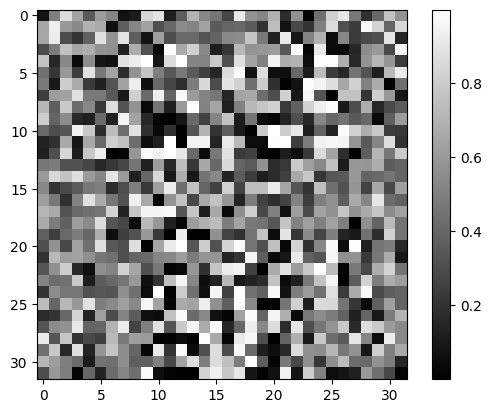

In [38]:
plt.imshow(gan.generate_data()[0, ..., 0], cmap="gray")
plt.colorbar()